In [6]:
import pandas as pd

# Load the dataset from a local file
file_path = "default of credit card clients.xls"  # Ensure this matches the file name exactly
data = pd.read_excel(file_path, header=1)

# Display basic information about the dataset
print(data.head())
print(data.info())


   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0   

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop unnecessary columns and handle missing values
data = data.dropna()  # Drop missing values

# Rename the target column for convenience
data.rename(columns={'default payment next month': 'Default'}, inplace=True)

# Separate features and target variable
X = data.drop(columns=['Default'])
y = data['Default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')


              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.64      0.36      0.47      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.81      0.79      6000

ROC-AUC Score: 0.6535838728503511


In [9]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# Train the model on the resampled data
model.fit(X_train_res, y_train_res)
y_pred_res = model.predict(X_test_scaled)

# Evaluate the model on resampled data
print(classification_report(y_test, y_pred_res))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred_res)}')


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4673
           1       0.55      0.46      0.50      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.68      0.69      6000
weighted avg       0.79      0.80      0.79      6000

ROC-AUC Score: 0.6759103387140706


In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

# Create the XGBoost model
xgb = XGBClassifier(random_state=42)

# Perform Grid Search
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_res, y_train_res)

# Best parameters
print("XGBoost Best parameters found: ", grid_search_xgb.best_params_)

# Make predictions with the best model
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Evaluate the XGBoost model
print(classification_report(y_test, y_pred_xgb))
print(f'XGBoost ROC-AUC Score: {roc_auc_score(y_test, y_pred_xgb)}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits
XGBoost Best parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.56      0.42      0.48      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.66      0.68      6000
weighted avg       0.78      0.80      0.79      6000

XGBoost ROC-AUC Score: 0.6621371534046296


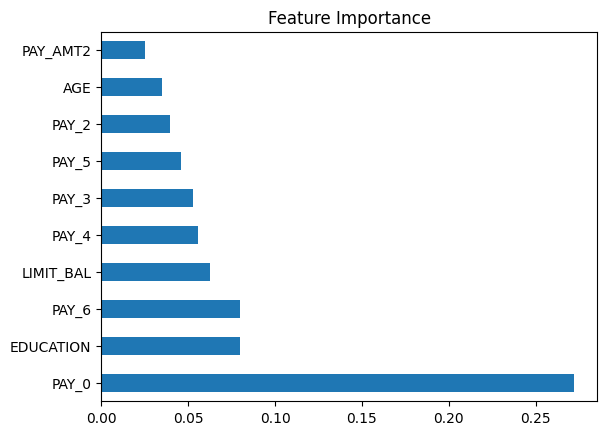

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance from the best XGBoost model
feature_importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.show()


In [12]:
from sklearn.ensemble import VotingClassifier

# Combine Random Forest and XGBoost models
voting_clf = VotingClassifier(estimators=[
    ('rf', model), 
    ('xgb', best_xgb)
], voting='soft')

# Train the ensemble model
voting_clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred_voting = voting_clf.predict(X_test_scaled)

# Evaluate the ensemble model
print(classification_report(y_test, y_pred_voting))
print(f'Ensemble ROC-AUC Score: {roc_auc_score(y_test, y_pred_voting)}')


              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.59      0.44      0.50      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.69      6000
weighted avg       0.79      0.81      0.80      6000

Ensemble ROC-AUC Score: 0.6761761798889256


In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution for RandomForest
param_dist_rf = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
}

# Define the parameter distribution for XGBoost
param_dist_xgb = {
    'n_estimators': randint(100, 1000),
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': randint(3, 30),
    'min_child_weight': randint(1, 10),
}

# Create the models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Perform Randomized Search for RandomForest
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=2)
random_search_rf.fit(X_train_res, y_train_res)
best_rf = random_search_rf.best_estimator_

# Perform Randomized Search for XGBoost
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist_xgb, n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=2)
random_search_xgb.fit(X_train_res, y_train_res)
best_xgb = random_search_xgb.best_estimator_

# Combine the models into an ensemble
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf), 
    ('xgb', best_xgb)
], voting='soft')

# Train the ensemble model
voting_clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred_voting = voting_clf.predict(X_test_scaled)

# Evaluate the ensemble model
print(classification_report(y_test, y_pred_voting))
print(f'Ensemble ROC-AUC Score: {roc_auc_score(y_test, y_pred_voting)}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.57      0.43      0.49      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.67      0.68      6000
weighted avg       0.79      0.80      0.79      6000

Ensemble ROC-AUC Score: 0.6679005933007378
